
# Barycenter of labeled graphs with FGW

This example illustrates the computation barycenter of labeled graphs using
FGW [18].

Requires networkx >=2

[18] Vayer Titouan, Chapel Laetitia, Flamary Rémi, Tavenard Romain
and Courty Nicolas
"Optimal Transport for structured data with application on graphs"
International Conference on Machine Learning (ICML). 2019.


In [1]:
# Author: Titouan Vayer <titouan.vayer@irisa.fr>
#
# License: MIT License

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import math
from scipy.sparse.csgraph import shortest_path
import matplotlib.colors as mcol
from matplotlib import cm
from ot.gromov import fgw_barycenters

In [3]:
def find_thresh(C, inf=0.5, sup=3, step=10):
    """Trick to find the adequate thresholds from where value of the C matrix are considered close enough to say that nodes are connected
        The threshold is found by a linesearch between values "inf" and "sup" with "step" thresholds tested.
        The optimal threshold is the one which minimizes the reconstruction error between the shortest_path matrix coming from the thresholded adjacency matrix
        and the original matrix.
    Parameters
    ----------
    C : ndarray, shape (n_nodes,n_nodes)
            The structure matrix to threshold
    inf : float
          The beginning of the linesearch
    sup : float
          The end of the linesearch
    step : integer
            Number of thresholds tested
    """
    dist = []
    search = np.linspace(inf, sup, step)
    for thresh in search:
        Cprime = sp_to_adjacency(C, 0, thresh)
        SC = shortest_path(Cprime, method="D")
        SC[SC == float("inf")] = 100
        dist.append(np.linalg.norm(SC - C))
    return search[np.argmin(dist)], dist


def sp_to_adjacency(C, threshinf=0.2, threshsup=1.8):
    """Thresholds the structure matrix in order to compute an adjacency matrix.
    All values between threshinf and threshsup are considered representing connected nodes and set to 1. Else are set to 0
    Parameters
    ----------
    C : ndarray, shape (n_nodes,n_nodes)
        The structure matrix to threshold
    threshinf : float
        The minimum value of distance from which the new value is set to 1
    threshsup : float
        The maximum value of distance from which the new value is set to 1
    Returns
    -------
    C : ndarray, shape (n_nodes,n_nodes)
        The threshold matrix. Each element is in {0,1}
    """
    H = np.zeros_like(C)
    np.fill_diagonal(H, np.diagonal(C))
    C = C - H
    C = np.minimum(np.maximum(C, threshinf), threshsup)
    C[C == threshsup] = 0
    C[C != 0] = 1

    return C


def build_noisy_circular_graph(
    N=20, mu=0, sigma=0.3, with_noise=False, structure_noise=False, p=None
):
    """Create a noisy circular graph"""
    g = nx.Graph()
    g.add_nodes_from(list(range(N)))
    for i in range(N):
        noise = np.random.normal(mu, sigma, 1)[0]
        if with_noise:
            g.add_node(i, attr_name=math.sin((2 * i * math.pi / N)) + noise)
        else:
            g.add_node(i, attr_name=math.sin(2 * i * math.pi / N))
        g.add_edge(i, i + 1)
        if structure_noise:
            randomint = np.random.randint(0, p)
            if randomint == 0:
                if i <= N - 3:
                    g.add_edge(i, i + 2)
                if i == N - 2:
                    g.add_edge(i, 0)
                if i == N - 1:
                    g.add_edge(i, 1)
    g.add_edge(N, 0)
    noise = np.random.normal(mu, sigma, 1)[0]
    if with_noise:
        g.add_node(N, attr_name=math.sin((2 * N * math.pi / N)) + noise)
    else:
        g.add_node(N, attr_name=math.sin(2 * N * math.pi / N))
    return g


def graph_colors(nx_graph, vmin=0, vmax=7):
    cnorm = mcol.Normalize(vmin=vmin, vmax=vmax)
    cpick = cm.ScalarMappable(norm=cnorm, cmap="viridis")
    cpick.set_array([])
    val_map = {}
    for k, v in nx.get_node_attributes(nx_graph, "attr_name").items():
        val_map[k] = cpick.to_rgba(v)
    colors = []
    for node in nx_graph.nodes():
        colors.append(val_map[node])
    return colors

## Generate data



We build a dataset of noisy circular graphs.
Noise is added on the structures by random connections and on the features by gaussian noise.



In [4]:
np.random.seed(30)
X0 = []
for k in range(9):
    X0.append(
        build_noisy_circular_graph(
            np.random.randint(15, 25), with_noise=True, structure_noise=True, p=3
        )
    )

## Plot data



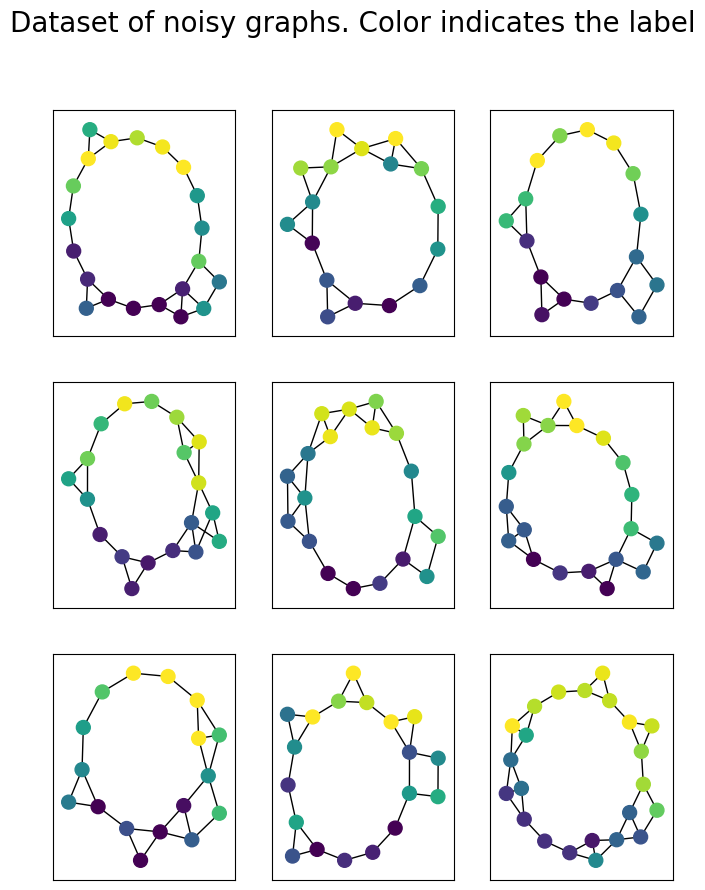

In [5]:
plt.figure(figsize=(8, 10))
for i in range(len(X0)):
    plt.subplot(3, 3, i + 1)
    g = X0[i]
    pos = nx.kamada_kawai_layout(g)
    nx.draw_networkx(
        g,
        pos=pos,
        node_color=graph_colors(g, vmin=-1, vmax=1),
        with_labels=False,
        node_size=100,
    )
plt.suptitle("Dataset of noisy graphs. Color indicates the label", fontsize=20)
plt.show()

## Barycenter computation



Features distances are the euclidean distances



In [25]:
Cs = [shortest_path(nx.adjacency_matrix(x).toarray()) for x in X0] # Shortest paths from each node to each node
ps = [np.ones(len(x.nodes())) / len(x.nodes()) for x in X0] # Uniform weights on the nodes
Ys = [
    np.array([1 for (k, v) in nx.get_node_attributes(x, "attr_name").items()]).reshape(
        -1, 1
    )
    for x in X0
] # Node attributes
lambdas = np.array([np.ones(len(Ys)) / len(Ys)]).ravel()
sizebary = 200  # we choose a barycenter with 15 nodes

A, C, log = fgw_barycenters(sizebary, Ys, Cs, ps, lambdas, alpha=0.95, log=True) # Returns: feature matrix, structure matrix and log dictionary

In [15]:
len(Cs), Cs[0].shape, Cs[1].shape, Ys[0].shape, A.shape, C.shape, C.min(), C.max()

(9,
 (21, 21),
 (17, 17),
 (21, 1),
 (200, 1),
 (200, 200),
 np.float64(0.0),
 np.float64(7.023391812865496))

## Plot Barycenter



In [16]:
bary = nx.from_numpy_array(
    sp_to_adjacency(C, threshinf=0, threshsup=find_thresh(C, sup=100, step=100)[0])
)
for i, v in enumerate(A.ravel()):
    bary.add_node(i, attr_name=v)

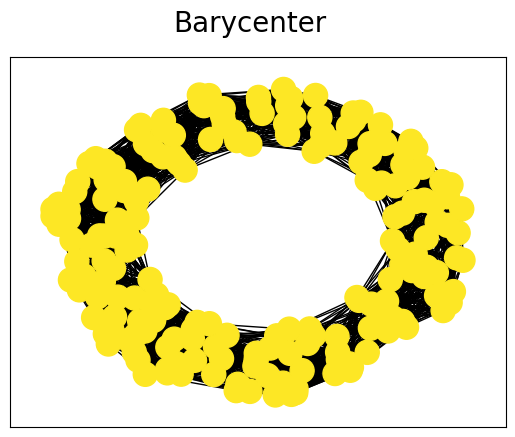

In [17]:
pos = nx.kamada_kawai_layout(bary)
nx.draw_networkx(
    bary, pos=pos, node_color=graph_colors(bary, vmin=-1, vmax=1), with_labels=False
)
plt.suptitle("Barycenter", fontsize=20)
plt.show()